### imports etc

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score


import networkx as nx
import matplotlib.pyplot as plt


### define the cross correlation percentile checker

In [2]:
def linear_crosscorrelation_checker(dataset_name, absolute_correlation_limit = 0.6):
    # The correlation limit will be used for both negative numbers less than the limit and positive larger than limit
    corrmatrix = dataset_name.corr()
    corrmatrix.reset_index(inplace=True)
    melted = corrmatrix.melt(id_vars='index')
    melted.columns = ['var1','var2','correlation']
    melted.loc[melted.correlation >= absolute_correlation_limit, 'toomuchcorr'] = 1
    melted.loc[melted.correlation <= (-absolute_correlation_limit), 'toomuchcorr'] = 1
    melted.toomuchcorr.fillna(0,inplace=True)
    melted = melted[melted.var1 != melted.var2]
    corrgrouped = pd.DataFrame(melted.groupby('var1').sum())
    corrgrouped.reset_index(inplace=True)
    print(len(corrgrouped[corrgrouped.toomuchcorr > 0]),'columns of ',len(dataset_name.columns),' columns are linearly crosscorrelated with at least one other')

## define the cross correlation vizualizer

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40

In [4]:
def crosscor_viz(dataset_name):

    numeric_vars = dataset_name.select_dtypes(exclude=['object']).columns

    corr = dataset_name[numeric_vars].corr().abs()


    G = nx.Graph()

    for ind in corr.index:
        for col in corr.columns:
            #print(ind,col,corr.ix[ind][col])
            tempval = corr[[col]][corr.index == ind].values[0][0]
            #G.add_edge(ind,col,weight= corr.ix[ind][col])
            G.add_edge(ind,col,weight= tempval)

    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 0.8]
    emid = [(u, v) for (u, v, d) in G.edges(data=True) if ((d['weight'] < 0.8) & (d['weight'] >= 0.6))]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if ((d['weight'] < 0.6) & (d['weight'] >= 0.4))]
    #emicro = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] < 0.4]

    pos = nx.circular_layout(G)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=100)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge,
                           width=5)
    nx.draw_networkx_edges(G, pos, edgelist=emid,
                           width=3, alpha=0.5, edge_color='blue',)
    nx.draw_networkx_edges(G, pos, edgelist=esmall,
                           width=1, alpha=0.5, edge_color='blue', style='--')
    #nx.draw_networkx_edges(G, pos, edgelist=emicro,
    #                       width=0, alpha=0.5, edge_color='blue', style=':')

    # labels

    
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='arial')

    plt.axis('off')
    plt.show()

### define the conversion to percent for certain prefixed columns

In [5]:
def convert_to_percent(dataset_name, list_of_column_prefixes):
    
    for prefix in list_of_column_prefixes:

        targetcolumns = []
        for item in list(dataset_name.columns):
            if prefix in item:
                targetcolumns.append(item)

        dataset_name[prefix+'_sum'] = dataset_name[targetcolumns].sum(axis=1)

        for column in targetcolumns:
            dataset_name[column+'_share'] = dataset_name[column] / dataset_name[prefix+'_sum']
            dataset_name[column+'_share'].fillna(0,inplace=True)
            dataset_name.drop([column],axis=1,inplace=True)

        dataset_name.drop([prefix+'_sum'],axis=1,inplace=True)

### define the conversion of "secondhalf" columns into "percent of all" for corresponding "all" columns

In [6]:
def secondhalf_becomes_percent(dataset_name):
    dualcolumns = []
    for item in list(dataset_name.columns):
        if 'all' in item:
            dualcolumns.append(item)

    dualcolumnsB = []
    for item in list(dataset_name.columns):
        if 'secondhalf' in item:
            dualcolumnsB.append(item)


    num = 0
    for col in dualcolumns:
        allcol = dualcolumns[num]
        secondhalfcol = dualcolumnsB[num]
        newname = secondhalfcol + '_' + 'increase'
        dataset_name[newname] = dataset_name[secondhalfcol] / dataset_name[allcol]
        dataset_name[newname].fillna(0,inplace=True)
        dataset_name.drop([secondhalfcol],axis=1,inplace=True)
        num = num+1
    

### fetch the data, merge and create train/test splits

In [7]:
originaldata = pd.read_csv('C:/ADS forum/motordataset.csv', encoding='utf-16', index_col=0)

In [8]:
originaldata.shape

(139754, 399)

In [9]:
additionaldata = pd.read_csv('C:/ADS forum/motordataset_additional_features_1.csv', encoding='utf-16', index_col=0)

In [10]:
additionaldata.shape

(139754, 3)

In [11]:
data0 = originaldata.merge(additionaldata,how='inner', on='anonymous_id')

In [12]:
data0.shape

(139754, 401)

In [13]:
data0.head(3)

anonymous_id  type  conversion_agri_all  conversion_agri_secondhalf  \
0       2747423     1                  0.0                         0.0   
1       4424404     2                  0.0                         0.0   
2        487892     1                  0.0                         0.0   

   conversion_agri_tools_all  conversion_agri_tools_secondhalf  \
0                        0.0                               0.0   
1                        0.0                               0.0   
2                        0.0                               0.0   

   conversion_bap_vertical_all  conversion_bap_vertical_secondhalf  \
0                          8.0                                 4.0   
1                          2.0                                 2.0   
2                          0.0                                 0.0   

   conversion_boat_all  conversion_boat_secondhalf  \
0                  0.0                         0.0   
1                  0.0                         0.0   
2                  0.0                         0.0   

   conversion_boat_vertical_all  conversion_boat_vertical_secondhalf  \
0                           0.0                                  0.0   
1                           0.0                                  0.0   
2                           0.0                                  0.0   

   conversion_bus_all  conversion_bus_secondhalf  conversion_car_leasing_all  \
0                 0.0                        0.0                         0.0   
1                 0.0                        0.0                         0.0   
2                 0.0                        0.0                         0.0   

   conversion_car_leasing_secondhalf  conversion_caravan_all  \
0                                0.0                     0.0   
1                                0.0                     0.0   
2                                0.0                     0.0   

   conversion_caravan_secondhalf  conversion_estate_sale_all  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   

   conversion_estate_sale_secondhalf  conversion_job_executive_all  \
0                                0.0                           0.0   
1                                0.0                           0.0   
2                                0.0                           0.0   

   conversion_job_executive_secondhalf  conversion_job_parttime_all  \
0                                  0.0                          0.0   
1                                  0.0                          0.0   
2                                  0.0                          0.0   

   conversion_job_parttime_secondhalf  conversion_job_all  \
0                                 0.0                 0.0   
1                                 0.0                 0.0   
2                                 0.0                 0.0   

   conversion_job_secondhalf  conversion_job_vertical_all  \
0                        0.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   

   conversion_job_vertical_secondhalf  conversion_mc_all  \
0                                 0.0                0.0   
1                                 0.0                0.0   
2                                 0.0                0.0   

   conversion_mc_secondhalf  conversion_mc_vertical_all  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   

   conversion_mc_vertical_secondhalf  conversion_mobile_home_all  \
0                                0.0                         0.0   
1                                0.0                         0.0   
2                                0.0                         0.0   

   conversio

In [14]:
## remove class 1 for now
data = data0.copy()[data0.type > 1]

# change the other two into 0 and 1 
data['class'] = 0
data.loc[data.type == 3, 'class'] = 1

# split
y = data['class']
X = data.drop(['anonymous_id','type','class','event_week','data_start_week','data_end_week'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
##rate of 1's
np.mean(y)

0.04174310773793069

In [15]:
linear_crosscorrelation_checker(X_train)

274 columns of  396  columns are linearly crosscorrelated with at least one other


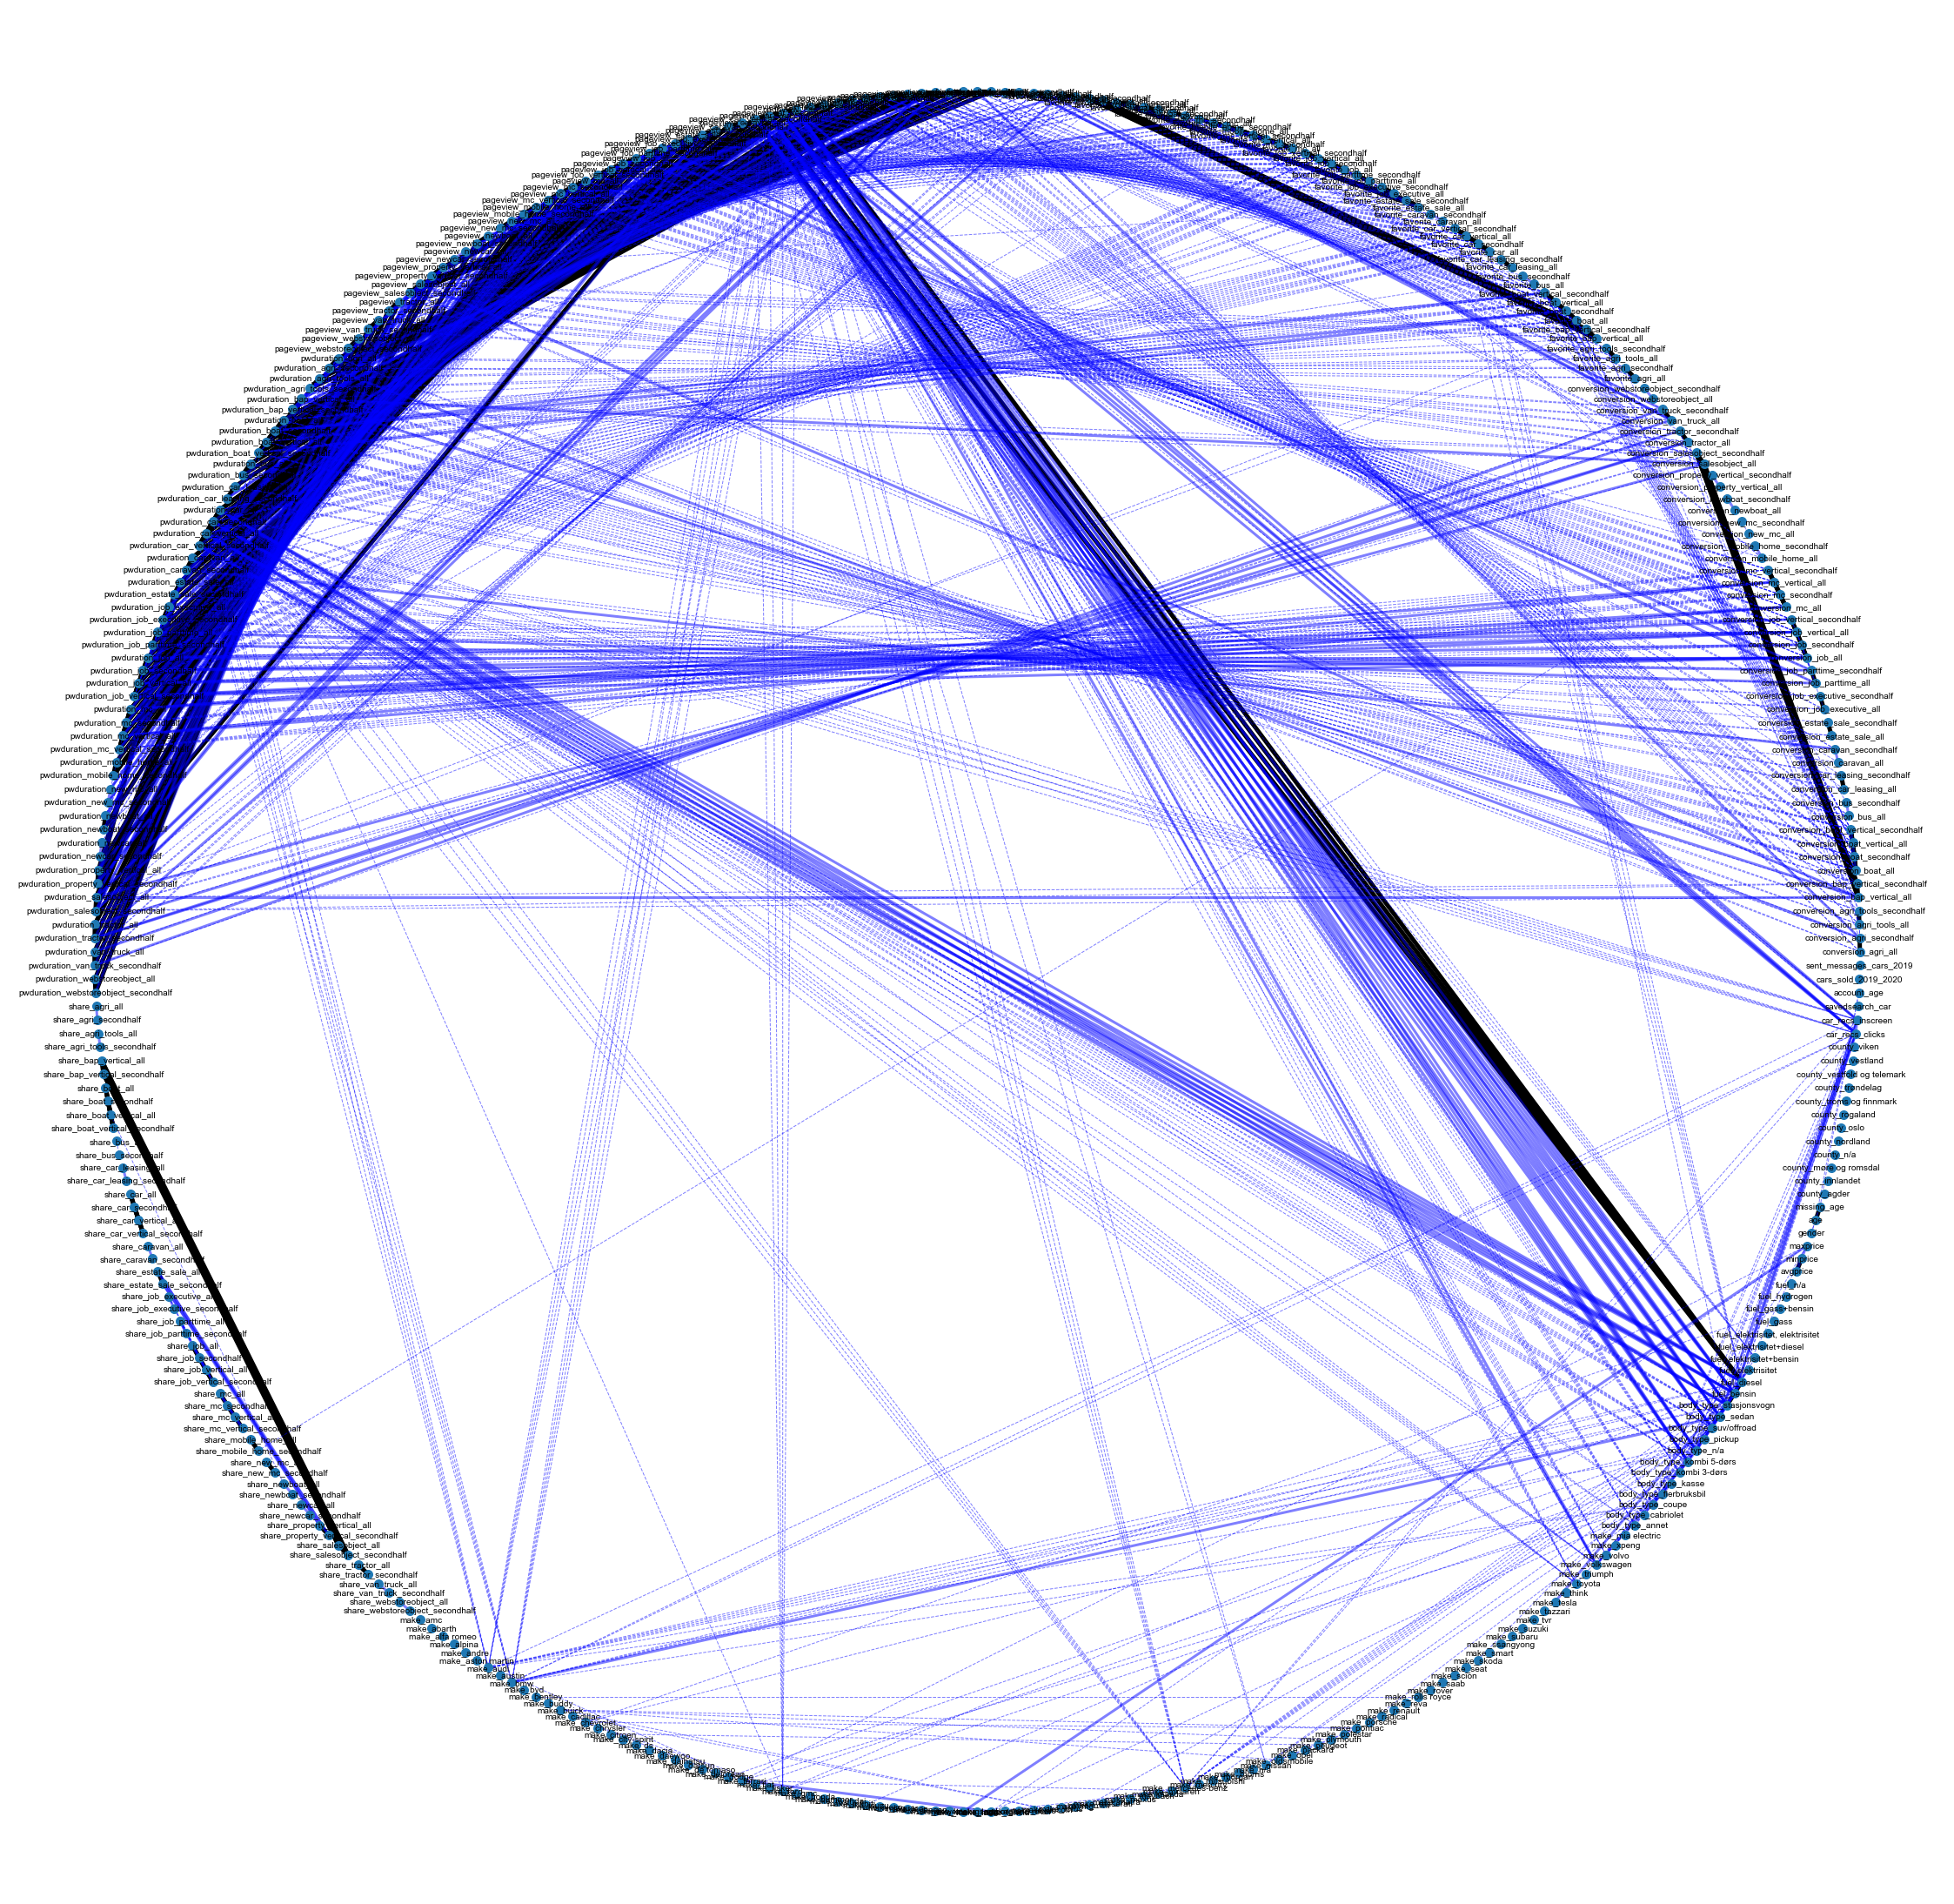

In [16]:
crosscor_viz(X_train)

### convert columns with certain prefixes into "share of own total" (and drop originals)

In [17]:
convert_to_percent(X_train,['make', 'body_type', 'fuel'])
convert_to_percent(X_test,['make', 'body_type', 'fuel'])


<ipython-input-5-c96f252e5084>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_name[prefix+'_sum'] = dataset_name[targetcolumns].sum(axis=1)
<ipython-input-5-c96f252e5084>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_name[column+'_share'] = dataset_name[column] / dataset_name[prefix+'_sum']
C:\Python\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [18]:
linear_crosscorrelation_checker(X_train)

257 columns of  396  columns are linearly crosscorrelated with at least one other


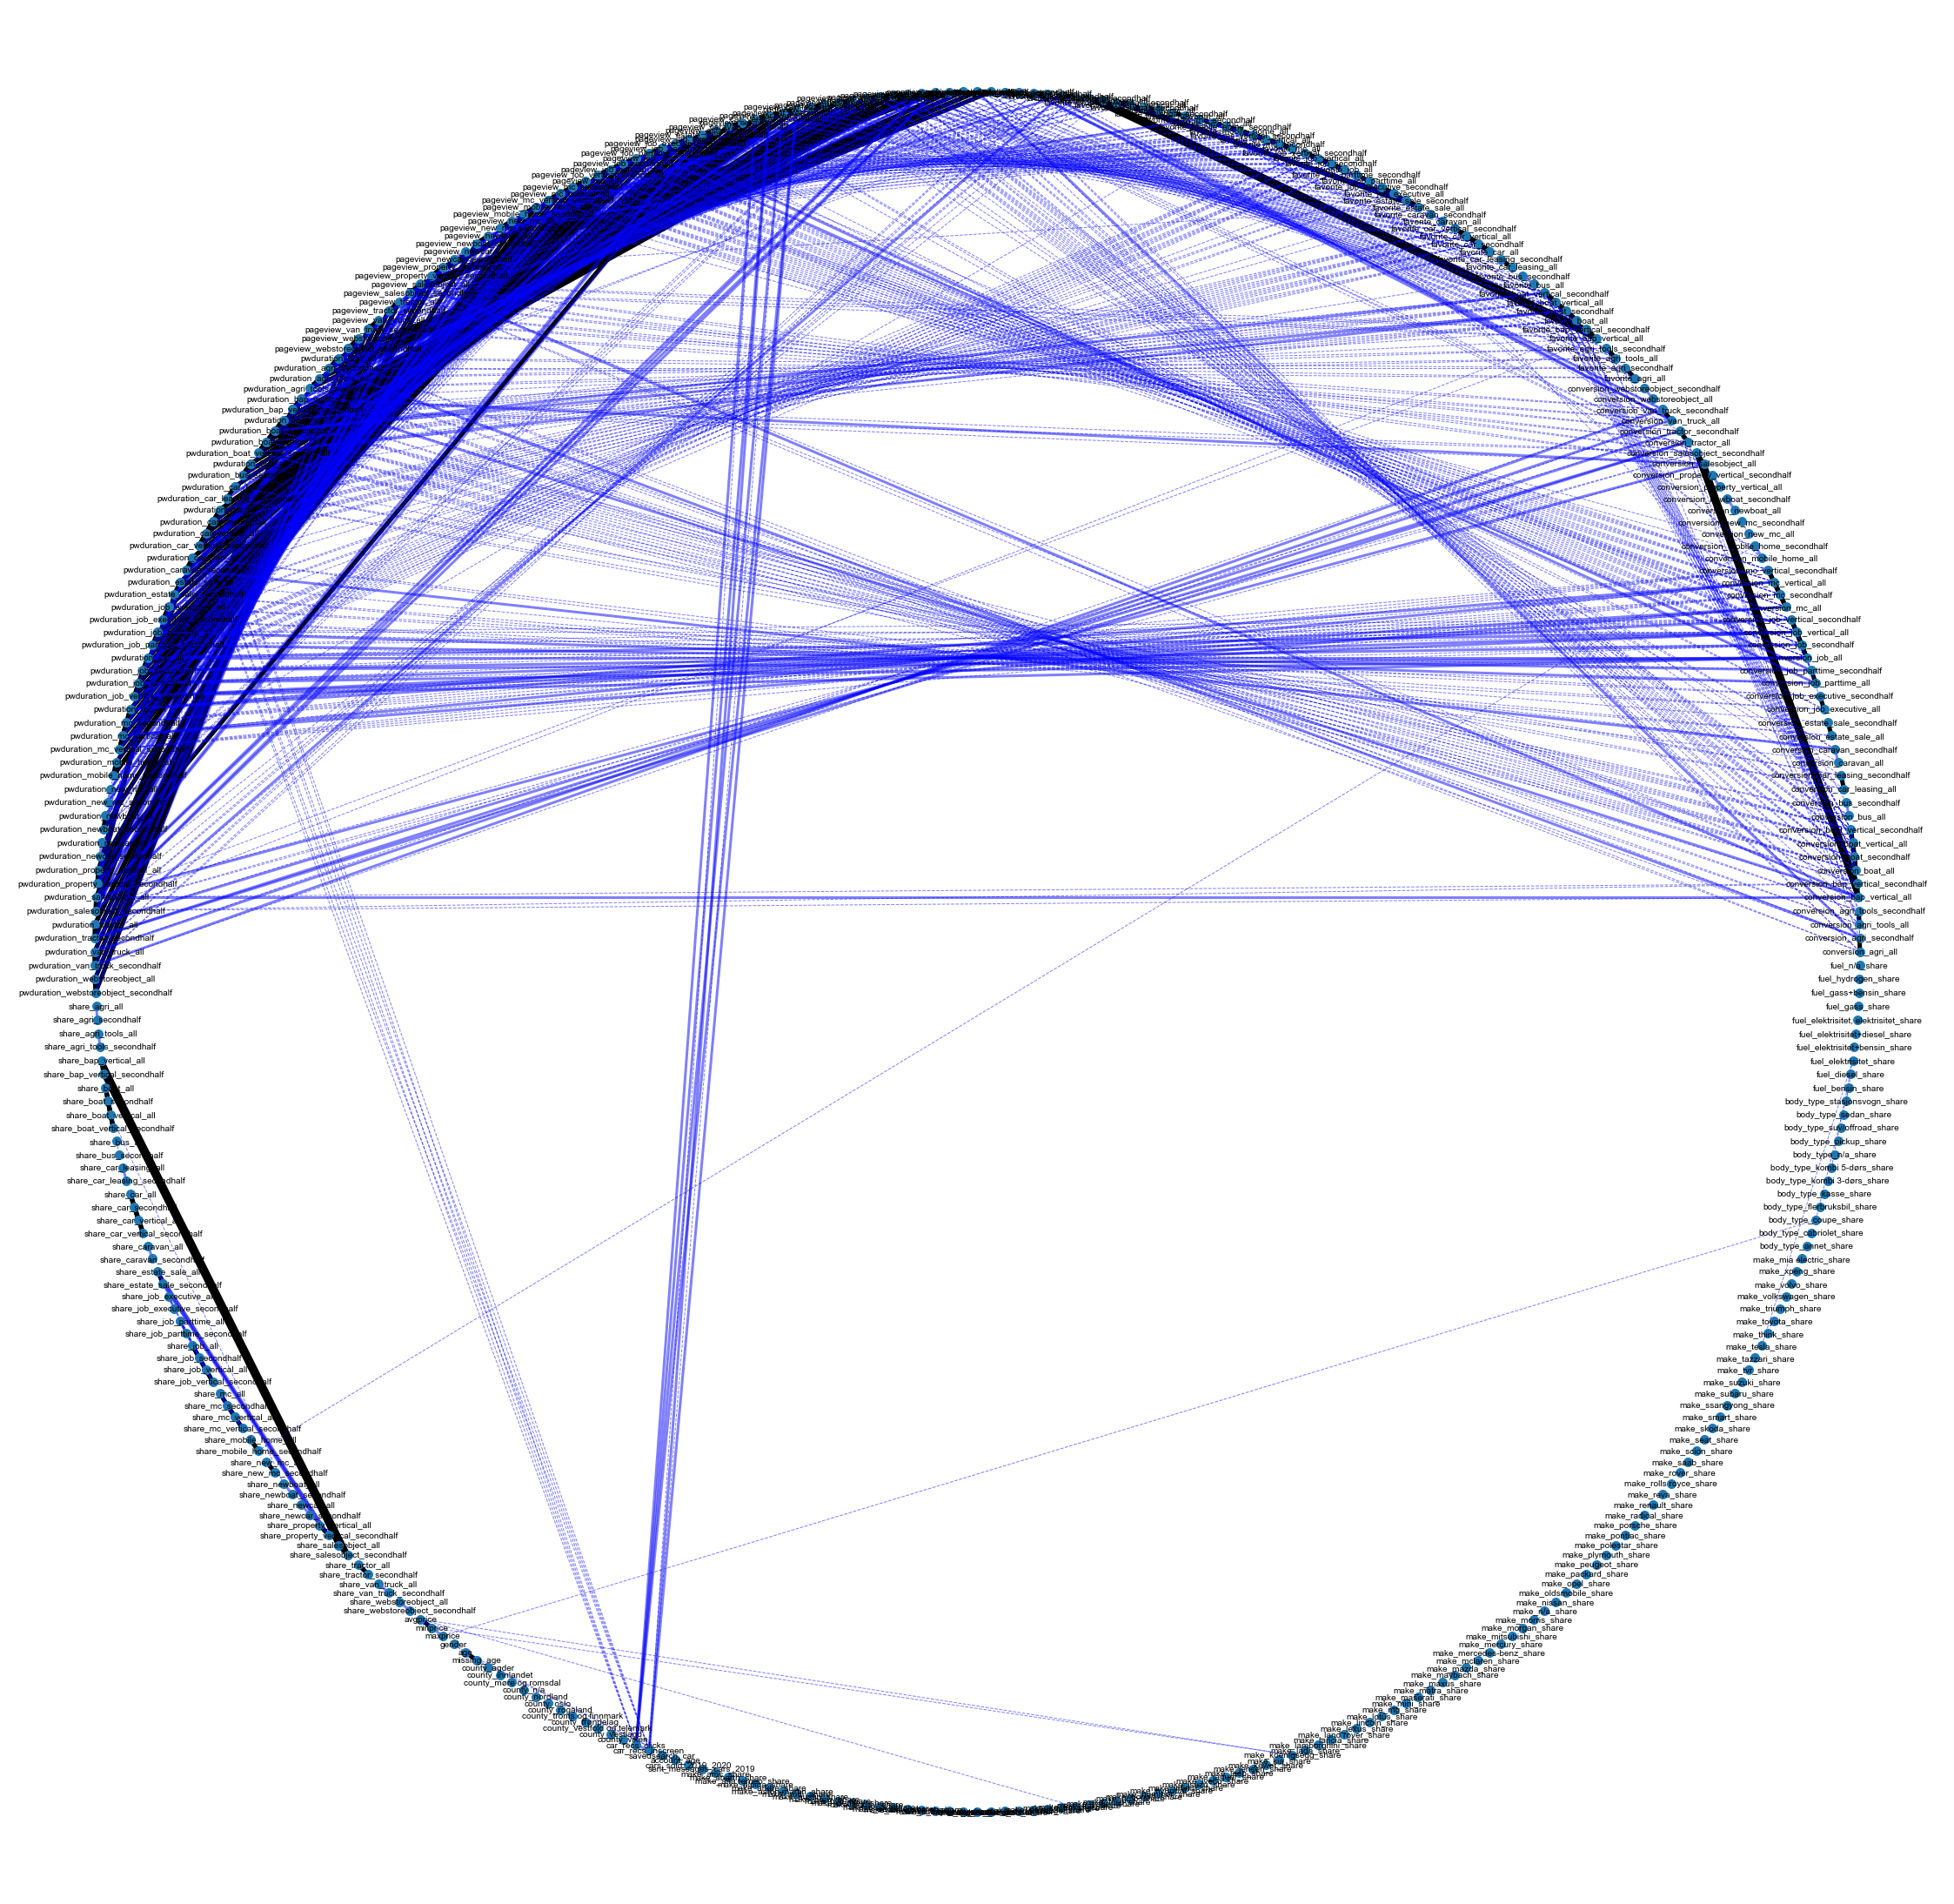

In [19]:
crosscor_viz(X_train)

### convert "secondhalf" columns into "percent of all" for corresponding "all" columns and drop originals

In [20]:
secondhalf_becomes_percent(X_train)
secondhalf_becomes_percent(X_test)

<ipython-input-6-890e2d2e2035>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_name[newname] = dataset_name[secondhalfcol] / dataset_name[allcol]


In [21]:
linear_crosscorrelation_checker(X_train)

187 columns of  396  columns are linearly crosscorrelated with at least one other


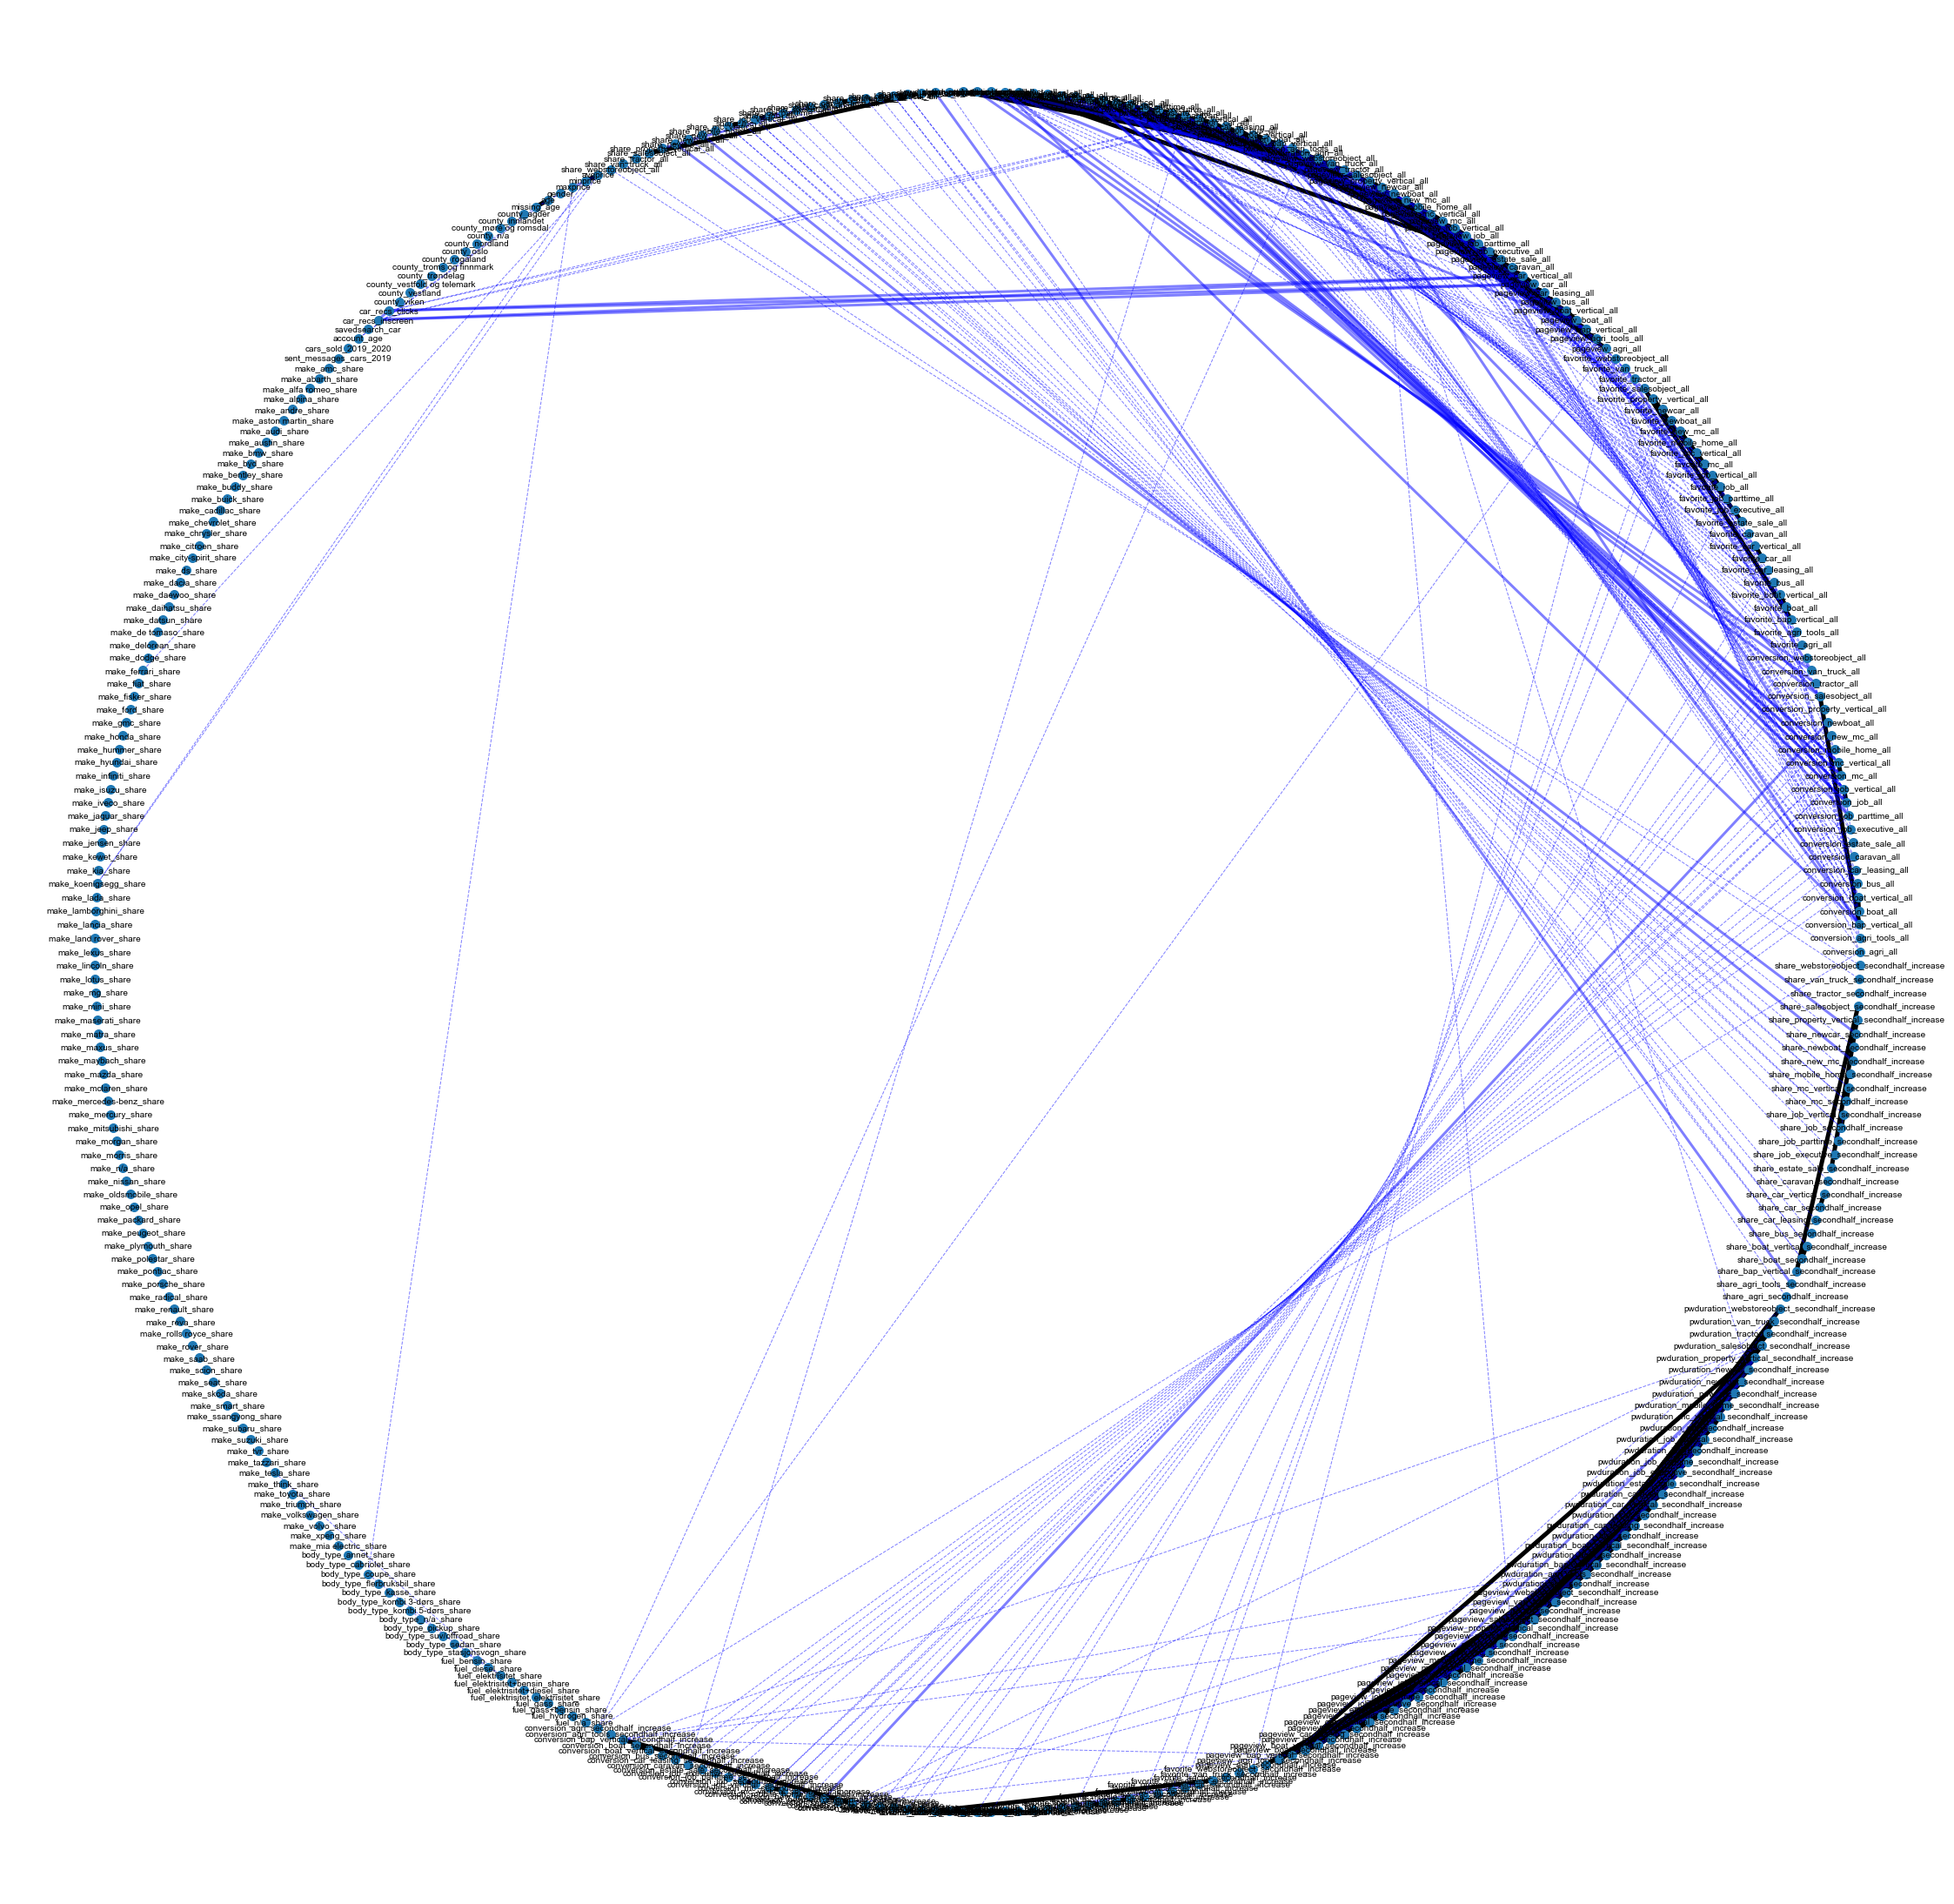

In [22]:
crosscor_viz(X_train)

### Perform test for each column to rank their their individual nonlinear solution power, and remove the 75% weakest columns

In [23]:
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20, class_weight='balanced')
resultlist = []
for column in X_train.columns:
    dt.fit(X_train[[column]],y_train)
    f1score = f1_score(y_train, dt.predict(X_train[[column]]))
    data = {'columnname': [column], 'f1score': [f1score]}
    resultlist.append(pd.DataFrame.from_dict(data))
    
resultframe = pd.concat(resultlist,axis=0)  
mostimportant_quartile = resultframe[resultframe.f1score >= np.percentile(resultframe.f1score, 75)]
X_train_selected = X_train[list(mostimportant_quartile.columnname.values)]
X_test_selected = X_test[list(mostimportant_quartile.columnname.values)]

In [24]:
linear_crosscorrelation_checker(X_train_selected)

44 columns of  99  columns are linearly crosscorrelated with at least one other


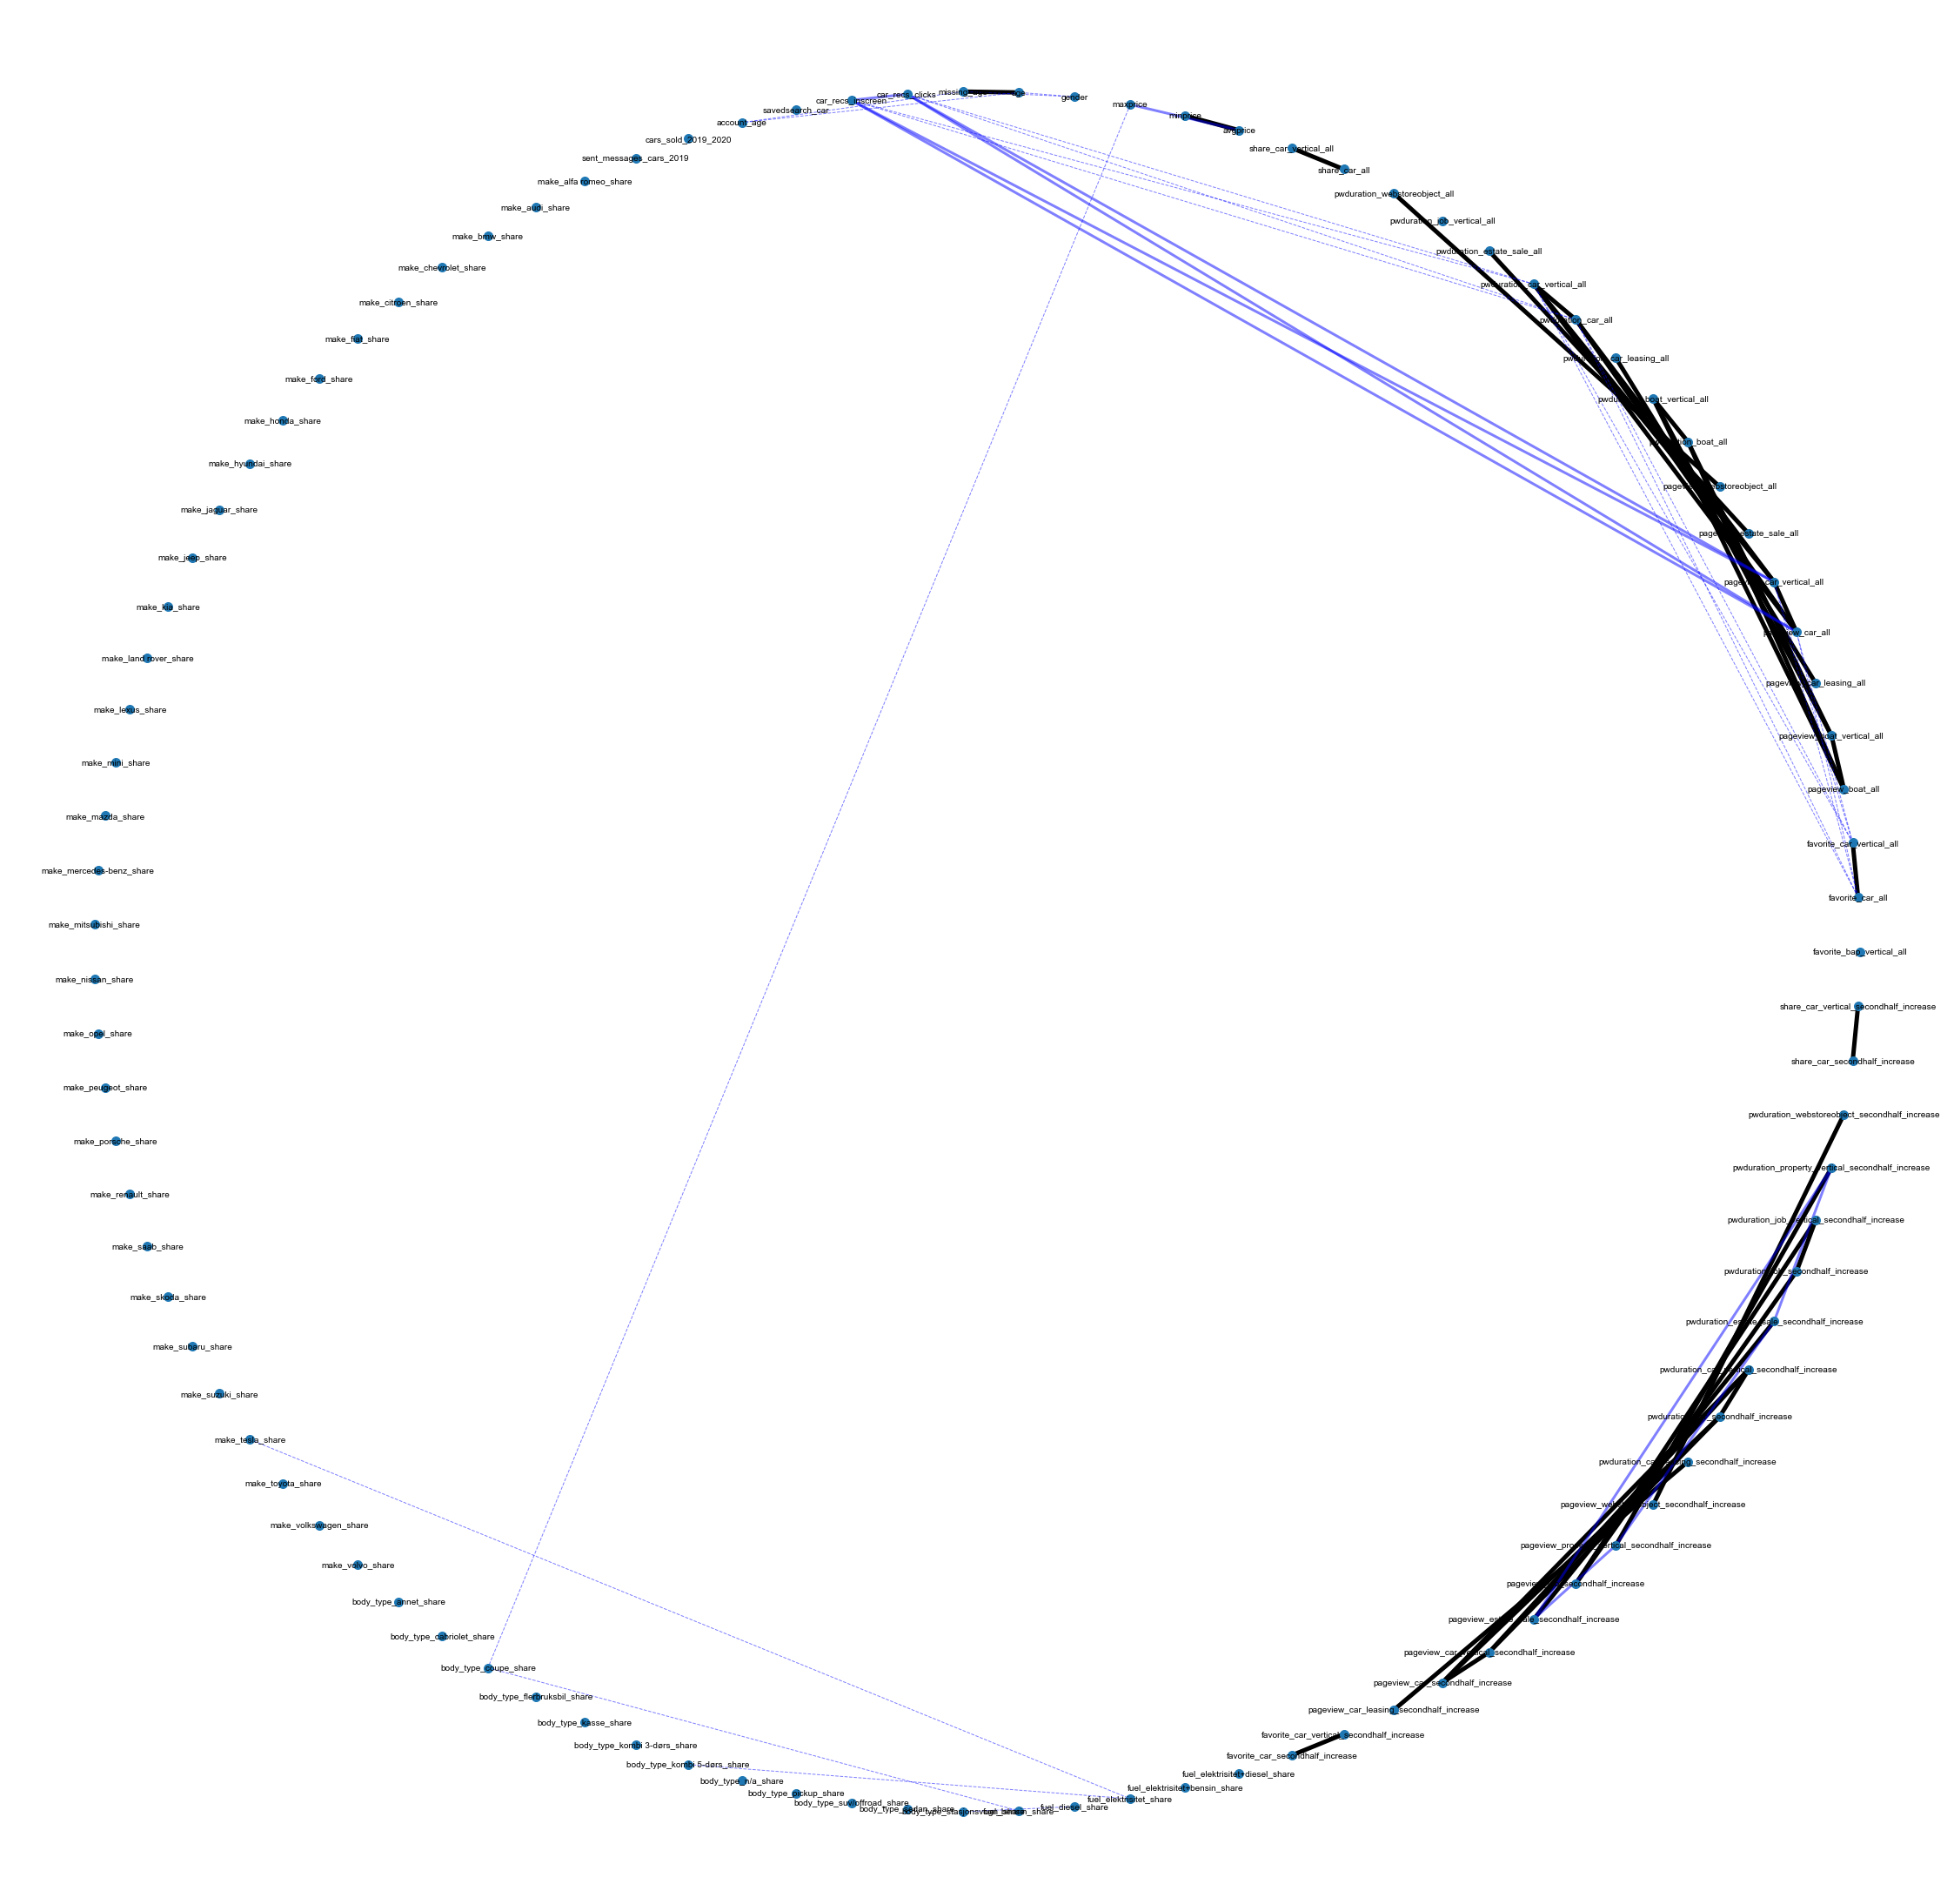

In [25]:
crosscor_viz(X_train_selected)

## use the results from the above ranking with correlation info to forcefully de-correlate remaining columns in prio order by converting to shares
#### this is highly manually specced to avoid division between different types of numbers and avoid extremly big numbers from dividing very large int on very small floats

In [26]:
corrmatrix = X_train_selected.corr()
corrmatrix.reset_index(inplace=True)
melted = corrmatrix.melt(id_vars='index')
melted.columns = ['var1','var2','correlation']
melted.loc[melted.correlation >= 0.6, 'toomuchcorr'] = 1
melted.loc[melted.correlation <= -0.6, 'toomuchcorr'] = 1
melted.toomuchcorr.fillna(0,inplace=True)
melted = melted[melted.var1 != melted.var2]
toomuchcorr = melted[melted.toomuchcorr == 1]
toomuchcorr2 = toomuchcorr.merge(mostimportant_quartile, how='inner', left_on='var1', right_on='columnname')
toomuchcorr2 = toomuchcorr2.sort_values(by='f1score',ascending=False)


num = 0
droplist = []
for number in range(0,len(toomuchcorr2)):

    temp = toomuchcorr2[num:(num+1)]
    if temp.var1.values[0] in droplist:
        num=(num+1)
    else:
        leftval = temp.var1.values[0]
        rightval = temp.var2.values[0]
        newname = rightval+'_over_'+leftval
        
        if (('share' in leftval) or ('increase' in leftval)) and (('share' not in rightval) and ('increase' not in rightval)):
            num=(num+1)
            
        if (('share' in rightval) or ('increase' in rightval)) and (('share' not in leftval) and ('increase' not in leftval)):
            num=(num+1)
        
        if (('share' in leftval) or ('increase' in leftval)) and (('share' in rightval) or ('increase' in rightval)):
            exec("X_train_selected.loc[X_train_selected."+leftval+" == 0,"+"'"+newname+"'] = (X_train_selected[rightval]+0.1) / (X_train_selected[leftval]+0.1)")
            exec("X_train_selected.loc[X_train_selected."+leftval+" != 0,"+"'"+newname+"'] = (X_train_selected[rightval]) / (X_train_selected[leftval])")
            exec("X_test_selected.loc[X_test_selected."+leftval+" == 0,"+"'"+newname+"'] = (X_test_selected[rightval]+0.1) / (X_test_selected[leftval]+0.1)")
            exec("X_test_selected.loc[X_test_selected."+leftval+" != 0,"+"'"+newname+"'] = (X_test_selected[rightval]) / (X_test_selected[leftval])")
            num=(num+1)
            droplist.append(rightval)
            
        if (('share' not in leftval) and ('increase' not in leftval)) and (('share' not in rightval) and ('increase' not in rightval)):
            exec("X_train_selected.loc[X_train_selected."+leftval+" == 0,"+"'"+newname+"'] = (X_train_selected[rightval]) / (X_train_selected[leftval]+1)")
            exec("X_train_selected.loc[X_train_selected."+leftval+" != 0,"+"'"+newname+"'] = (X_train_selected[rightval]) / (X_train_selected[leftval])")
            exec("X_test_selected.loc[X_test_selected."+leftval+" == 0,"+"'"+newname+"'] = (X_test_selected[rightval]) / (X_test_selected[leftval]+1)")
            exec("X_test_selected.loc[X_test_selected."+leftval+" != 0,"+"'"+newname+"'] = (X_test_selected[rightval]) / (X_test_selected[leftval])")
            num=(num+1)
            droplist.append(rightval)

X_train_selected.drop(list(set(droplist)),axis=1,inplace=True)
X_test_selected.drop(list(set(droplist)),axis=1,inplace=True)

C:\Python\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Python\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [27]:
linear_crosscorrelation_checker(X_train_selected)

16 columns of  101  columns are linearly crosscorrelated with at least one other


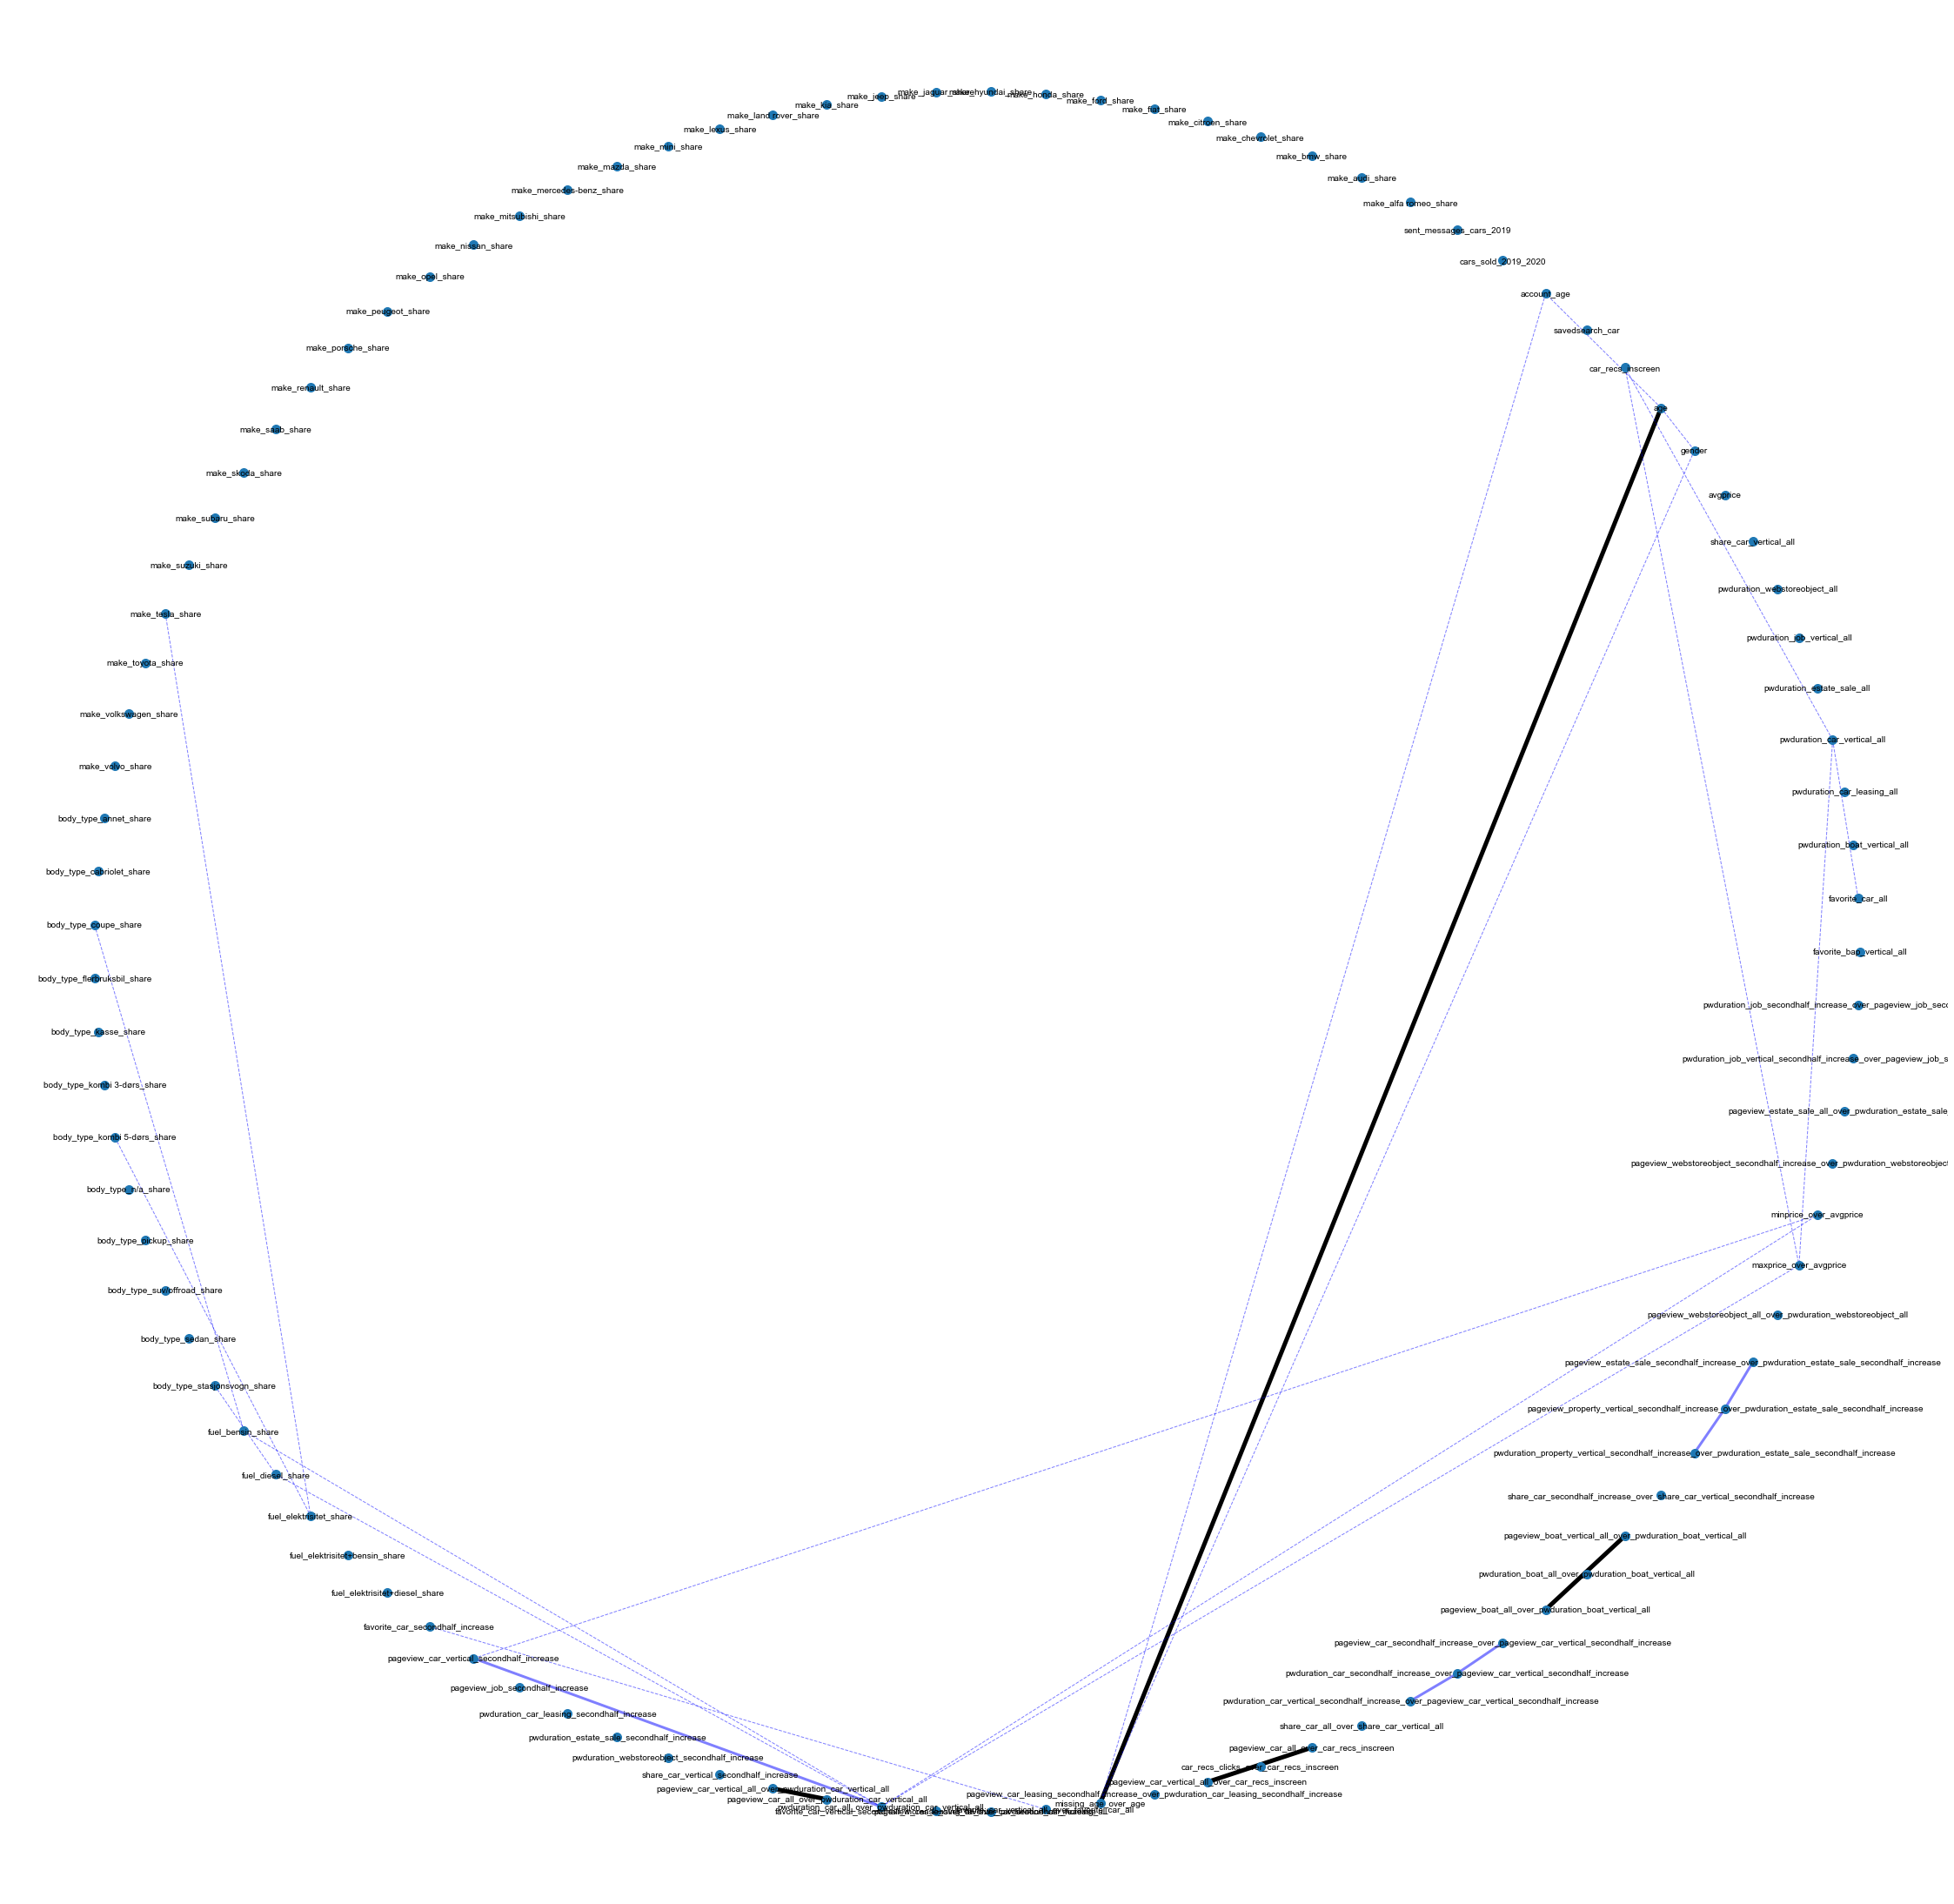

In [28]:
crosscor_viz(X_train_selected)

### perform permutation importance to determine column importance for the problem, and keep the most powerful 20% (this is best when cross correlation is already minimized)

In [29]:
rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=10, class_weight='balanced').fit(X_train_selected, y_train)
result = permutation_importance(rf, X_train_selected, y_train, n_repeats=3, random_state=0)


In [30]:
importances = pd.DataFrame(result.importances_mean).T
importances.columns = X_train_selected.columns
importances = importances.T
importances.reset_index(inplace=True)
importances.columns = ['feature','importance']

In [31]:
importances.describe()

importance
count  101.000000
mean    -0.000304
std      0.002532
min     -0.006014
25%     -0.001175
50%     -0.000050
75%      0.000213
max      0.014417

In [32]:
newcolumnsA = list(importances[importances.importance > np.percentile(importances.importance,80)].feature)

In [33]:
len(newcolumnsA)

20

In [34]:
X_train_final = X_train_selected[newcolumnsA]
X_test_final = X_test_selected[newcolumnsA]

In [35]:
for col in X_train_final.columns:
    print(col)

pwduration_car_vertical_all
gender
age
savedsearch_car
account_age
cars_sold_2019_2020
sent_messages_cars_2019
make_subaru_share
make_tesla_share
make_volvo_share
body_type_annet_share
body_type_cabriolet_share
body_type_flerbruksbil_share
body_type_kombi 3-dørs_share
body_type_kombi 5-dørs_share
body_type_sedan_share
body_type_stasjonsvogn_share
favorite_car_secondhalf_increase
missing_age_over_age
pageview_boat_all_over_pwduration_boat_vertical_all


In [36]:
## grid search for best model

In [37]:
from sklearn.metrics import fbeta_score, make_scorer, precision_score, recall_score, confusion_matrix
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [38]:
from sklearn.model_selection import GridSearchCV
parameters = {'min_samples_leaf':[5,10,20,50], 'max_features':['auto', 0.5,0.75]}
rf = RandomForestClassifier(n_estimators=500,class_weight='balanced')
#rf = XGBClassifier()


In [39]:
#parameters = {'base_score':[0.1], 'learning_rate':[0.0001, 0.001, 0.01, 0.1],'max_depth':[20], 'scale_pos_weight':[20,10,5],'n_estimators':[500],'n_jobs':[4]}

In [40]:

clf = GridSearchCV(rf, parameters,scoring=fhalf_scorer, n_jobs=4,verbose=4,cv=3)
clf.fit(X_train_final, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  2.5min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_estimators=500),
             n_jobs=4,
             param_grid={'max_features': ['auto', 0.5, 0.75],
                         'min_samples_leaf': [5, 10, 20, 50]},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=4)

In [41]:
clf.best_params_

{'max_features': 'auto', 'min_samples_leaf': 10}

In [42]:
clf.best_estimator_

RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       n_estimators=500)

In [43]:
probs = clf.predict_proba(X_test_final)

resultlist = []
for num in range(10,100,5):
    ones = (probs[:,1] >= (num/100)).astype(int)
    oddscut =  num
    prec = precision_score(y_test,ones,pos_label=1,average='binary')
    rec = recall_score(y_test,ones,pos_label=1,average='binary')
    guessrate = np.mean(ones) 
    
    CM = confusion_matrix(y_test, ones)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    dict_ = {'proba': [oddscut], 'precision': [prec], 'recall': [rec], 'guessrate':[guessrate], 'TPR':[TPR], 'FPR':[FPR]}
    resultlist.append(pd.DataFrame(dict_))


C:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
pd.concat(resultlist,axis=0).to_csv('C:/python/adsforum_prec_rec_curve.csv')


## lift curve

In [65]:
testframe = pd.DataFrame(y_test)
testframe['pred'] = probs[:,1]
testframe['pred_rounded'] = ((testframe['pred']*20).astype(int))/20

In [66]:
liftframe = pd.concat((testframe[['pred_rounded','class']].groupby('pred_rounded').mean().reset_index(),testframe[['pred_rounded','class']].groupby('pred_rounded').size().reset_index()),axis=1)
liftframe.columns = ['proba_group','ratio_1s','proba2','total_N_in_group']
liftframe['total_1_in_group'] = liftframe.ratio_1s * liftframe.total_N_in_group
liftframe.drop(['proba2'],axis=1,inplace=True)
liftframe['lift'] = liftframe['ratio_1s'] / np.mean(y)
liftframe

proba_group  ratio_1s  total_N_in_group  total_1_in_group       lift
0          0.00  0.007117               281               2.0   0.170506
1          0.05  0.012227              1145              14.0   0.292912
2          0.10  0.032945              1973              65.0   0.789226
3          0.15  0.030388              2139              65.0   0.727977
4          0.20  0.050318              1888              95.0   1.205416
5          0.25  0.034266              2072              71.0   0.820888
6          0.30  0.037199              1828              68.0   0.891144
7          0.35  0.062660               782              49.0   1.501082
8          0.40  0.057034               526              30.0   1.366315
9          0.45  0.092664               259              24.0   2.219866
10         0.50  0.109091               110              12.0   2.613387
11         0.55  0.112676                71               8.0   2.699273
12         0.60  0.200000                25               5.0   4.791210
13         0.65  0.307692                13               4.0   7.371092
14         0.70  0.222222                 9               2.0   5.323567
15         0.75  0.200000                 5               1.0   4.791210
16         0.80  1.000000                 3               3.0  23.956051
17         0.85  1.000000                 1               1.0  23.956051
18         0.90  1.000000                 2               2.0  23.956051

## interrogate model for its logic

In [101]:
import skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(training_data=X_train_final, feature_names=list(X_train_final.columns))
model = InMemoryModel(clf.predict_proba, examples = X_train_final)

from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool

targetcolumns = X_train_final.columns
condframe_all_temp = []



def interpret_column(column):
    condprob = interpreter.partial_dependence.partial_dependence([column],model, n_samples=10000, n_jobs=1, progressbar=False)
    condprob_frame = pd.DataFrame(condprob)
    condprob_frame.columns = ['X_value','y_value','sd']
    condprob_frame['var'] = column
    condframe_all_temp.append(condprob_frame)

pool = ThreadPool(4)
#timefull = time.time()
results = pool.map(interpret_column, targetcolumns)

pool.close()
pool.join()
#print('for',4,'threads, entire loop took',time.time()-timefull,'seconds')

condframe_all = pd.concat(condframe_all_temp,axis=0)
condframe_all['medianpred'] = np.median(clf.predict_proba(X_train_final))
condframe_all['meanpred'] = np.mean(clf.predict(X_train_final))

#condframe_all.to_csv('C:/python/conditional_probs_adsforum_20210503.csv')